Use a efficient policy to provide the first experience of the model

In [1]:
# CartPole-v1 using Q-learning

import gym
import cartpole
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Linear regression
from sklearn.linear_model import LinearRegression

from collections import deque

import random

from tensorflow import keras

from tqdm import tqdm

import multiprocessing

import time

sns.set_style("darkgrid")

In [20]:
class solver:
    def __init__(self, state_space, action_space, max_memory=10000, epsilon_exploration = 0.5, exploration_decay = 0.95,gamma = 0.95, learning_rate = 0.1):
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon_exploration = epsilon_exploration
        self.exploration_decay = exploration_decay
        self.gamma = gamma
        self.learning_rate = learning_rate
        #self.discount = discount

        #Define the memory
        self.memory = deque()
        self.max_memory = max_memory

        #Define the model to approximate the Q function
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(32, input_dim=state_space, activation='relu'))
        self.model.add(keras.layers.Dropout(0.3))
        self.model.add(keras.layers.Dense(32, activation='relu')) #Hidden layer
        self.model.add(keras.layers.Dense(action_space, activation='linear')) #expected reward for each action
        #self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01)) #Apparently not a good idea in RL
        self.model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.001, rho = 0.95, epsilon = 0.01), loss='mse')

    def new_experience(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])

    def act(self, state):
        #Explore
        if np.random.rand() <= self.epsilon_exploration:
            return np.random.randint(self.action_space) #Assuming start value is 0
        #Else exploit
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        #Get a batch of experiences
        if len(self.memory) < batch_size:
            return
        else:
            batch = random.choices(self.memory, k=batch_size) #state, action, reward, next_state, done
            state, action, reward, next_state, done = map(np.array, zip(*batch))
                #Compute the target
                    #Applying the Bellman equation
            
            target = reward + self.gamma * np.amax(self.model.predict(np.concatenate(next_state, axis=0), verbose=0)) * (1 - done)
            #Compute the target for the action
            target_f = self.model.predict(np.concatenate(state), verbose=0)
            #update for each target on the action coordinate
            target_f[np.arange(len(action)), action] = (1- self.learning_rate)* target_f[np.arange(len(action)), action] + self.learning_rate*target
            #Train the model
            state = np.concatenate(state)
            
            self.model.fit(state, target_f, epochs=1, verbose=0, batch_size=1)

            self.epsilon_exploration *= self.exploration_decay
            self.epsilon_exploration = max(0.05, self.epsilon_exploration)

    def run_efficient_policy(self):
        nb_episodes = 1
        epsilon = 0.1

        

        env = cartpole.CartPoleEnv(3)
        for i in tqdm(range(nb_episodes)):
            env.reset()
            observation, reward, done, info = env.step(2)
            done = False
            steps = 1
            while not done:
                #env.render()
                steps+=1
                old_state = np.reshape(observation, [1, self.state_space])
                if np.abs(observation[3]) > epsilon:
                    if observation[3] < 0:
                        action = 0
                        observation, reward, done, info = env.step(action)
                    else:
                        action = 1
                        observation, reward, done, info = env.step(action)
                else:
                    if observation[2] < 0:
                        action = 0
                        observation, reward, done, info = env.step(action)
                    else:
                        action = 1
                        observation, reward, done, info = env.step(action)
            observation = np.reshape(observation, [1, self.state_space])
            self.new_experience(old_state, action, reward, observation, done)

        env.close()

In [21]:
#Training the model

nb_episodes = 5
state_dim = 4
action_dim = 3 # 3 actions : left, right, do nothing

env_DQN = cartpole.CartPoleEnv()
agent = solver(state_dim, action_dim)
agent.run_efficient_policy()
agent.replay(batch_size=1000)
timesteps = 1
scores_DQN = list()
steps_history_DQN = list()
for episode in tqdm(range(nb_episodes)):
    state = env_DQN.reset()
    state = np.reshape(state, [1, state_dim])
    done = False
    score = 0
    steps  = 0
    while not done:
        steps += 1
        action = agent.act(state)
        next_state, reward, done, _ = env_DQN.step(action)
        next_state = np.reshape(next_state, [1, state_dim])
        if not done:
            reward = reward
        else:
            reward = -reward
        agent.new_experience(state, action, reward, next_state, done)
        state = next_state
        score += reward
        agent.replay() #Learn from the experience
    if episode % timesteps == 0:
        #print(steps)
        scores_DQN.append(score)
        steps_history_DQN.append(steps)
        

#Save the model
agent.model.save('model_DQN_replay_permament.h5')

100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


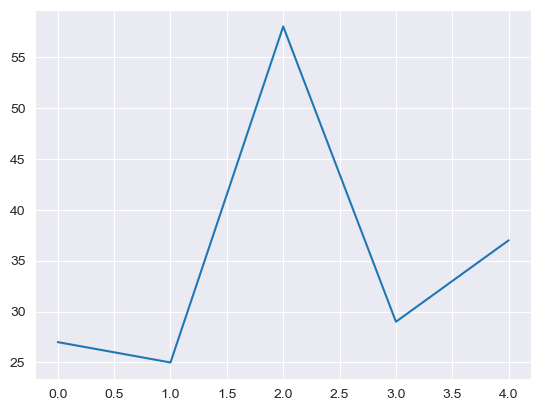

In [23]:
plt.plot(steps_history_DQN)